### Import Libraries

In [1]:
from huggingface_hub import notebook_login
from datasets import list_datasets
from datasets import load_dataset
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.functional import cross_entropy


import pandas as pd
import torch
import numpy as np
from umap import UMAP

2024-05-04 23:58:39.308440: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 23:58:39.368298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 23:58:40.221140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer.vocab_size

30522

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### Erster Blick in die Daten

In [4]:
all_datasets = list_datasets()
print(f"Derzeit sind {len(all_datasets)} Datensätze auf dem Hugging Face Hub verfügbar")
print(f"Die ersten 10 Datensätze sind: {all_datasets[:10]}")

/tmp/ipykernel_463468/3505647632.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


Derzeit sind 141121 Datensätze auf dem Hugging Face Hub verfügbar
Die ersten 10 Datensätze sind: ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [5]:
emotions = load_dataset("emotion")
emotions

/home/chandrsangee@edu.local/miniconda3/envs/tf/lib/python3.12/site-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
len(train_ds)
print(f"Der Datensatz enthält {len(train_ds)} Beispiele")
print(f"Das erste Beispiel ist: {train_ds[0]}")
print(f"Colums: {train_ds.column_names}")
print(f"Features: {train_ds.features}")

Der Datensatz enthält 16000 Beispiele
Das erste Beispiel ist: {'text': 'i didnt feel humiliated', 'label': 0}
Colums: ['text', 'label']
Features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [8]:
print(f"Die ersten 5 Beispiele sind: {train_ds[:5]}")
print(f"Die ersten 5 Labels sind: {train_ds['label'][:5]}")
print(f"Die ersten 5 Texte sind: {train_ds['text'][:5]}")

Die ersten 5 Beispiele sind: {'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
Die ersten 5 Labels sind: [0, 0, 3, 2, 3]
Die ersten 5 Texte sind: ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### Dataset-Objekte in DataFrames überführen

In [9]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
def label_to_string(label):
    return emotions["train"].features["label"].int2str(label)

df["label_name"] = df["label"].apply(label_to_string)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Blick in die Verteilung der Kateogrien

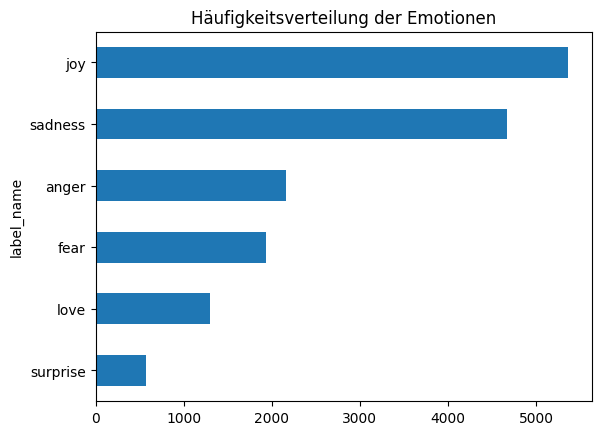

In [11]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Häufigkeitsverteilung der Emotionen")
plt.show()

### Wie lange sind unsere Tweets?

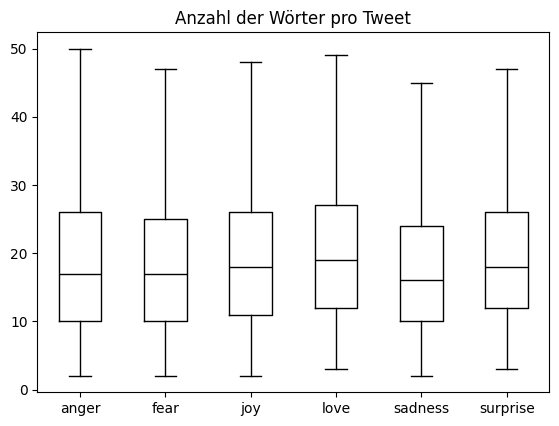

In [12]:
df["Anzahl der Wörter pro Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Anzahl der Wörter pro Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [13]:
emotions.reset_format()

### Den gesamten Datensatz tokenisieren

In [14]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [15]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [16]:
print(emotions_encoded["train"][:1])
print(emotions_encoded["train"].column_names)

{'text': ['i didnt feel humiliated'], 'label': [0], 'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}
['text', 'label', 'input_ids', 'attention_mask']


### Die letzten verborgenen Zustände extrahieren

In [17]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_states = model(**inputs).last_hidden_state
    return {"hidden_states": last_hidden_states[:, 0].cpu().numpy()}

In [18]:
emotions_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=16)

In [19]:
emotions_hidden["train"][:1]
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_states']

### Feature Matrix erstellen

In [20]:
X_train = np.array(emotions_hidden["train"]["hidden_states"])
X_valid = np.array(emotions_hidden["validation"]["hidden_states"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((16000, 768), (2000, 768), (16000,), (2000,))

### Trainingsdatensatz visualisieren

In [21]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.transform(X_scaled), columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.401570,6.142541,0
1,-3.152638,5.777603,0
2,5.315816,2.777128,3
3,-2.690904,3.641217,2
4,-3.495708,3.883143,3


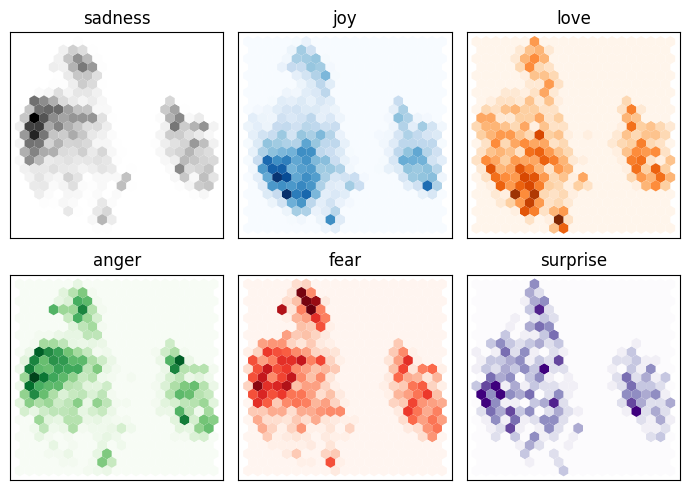

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps= ["Greys", "Blues", "Oranges", "Greens", "Reds", "Purples"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels,cmaps)):
    df_emb_sub = df_emb[df_emb["label"] == i]
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], gridsize=20, cmap=cmap, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

### Einen einfachen Klassifikator trainieren

In [23]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

In [24]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

### Konfusionsmatrix

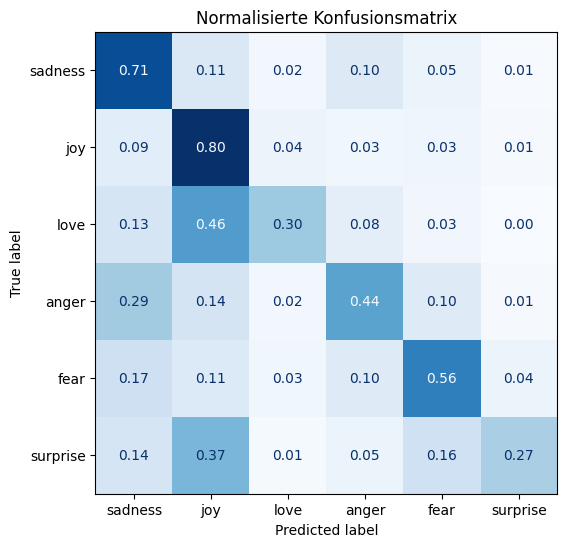

In [25]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalisierte Konfusionsmatrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Feintuning des Modells

### Ein vortrainiertes Modell verwenden

In [26]:
num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Qualitätsmasse festlegen

In [27]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy": acc}

### Modell trainieren

In [28]:
notebook_login()

In [29]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotions"
training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=2,
                                    learning_rate = 2e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    push_to_hub=True,
                                    save_strategy="epoch",
                                    load_best_model_at_end=True,
                                    log_level="error")

In [30]:
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

/home/chandrsangee@edu.local/miniconda3/envs/tf/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.848300,0.332136,0.906324,0.907500
2,0.266400,0.220443,0.927006,0.927000


TrainOutput(global_step=500, training_loss=0.5573654022216797, metrics={'train_runtime': 58.5476, 'train_samples_per_second': 546.564, 'train_steps_per_second': 8.54, 'total_flos': 720342861696000.0, 'train_loss': 0.5573654022216797, 'epoch': 2.0})

In [31]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.22044287621974945,
 'test_f1': 0.927005845322292,
 'test_accuracy': 0.927,
 'test_runtime': 0.9971,
 'test_samples_per_second': 2005.834,
 'test_steps_per_second': 32.093}

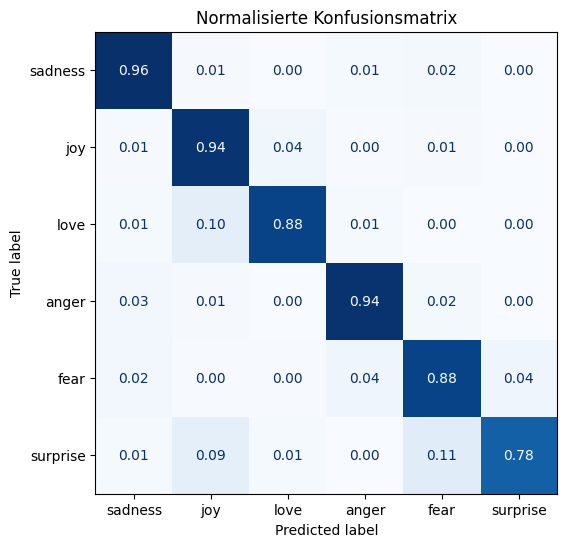

In [32]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fehleranalyse

In [33]:
def forward_pass_with_label(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits, axis=-1)
        loss = cross_entropy(outputs.logits, batch["label"].to(device), reduction="none")
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [34]:
emotions_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

emotions_encoded["validation"]= emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [35]:
emotions_encoded.set_format(type="pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_to_string)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_to_string)

In [36]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.667745
1801,i feel that he was being overshadowed by the s...,love,sadness,5.561604
1950,i as representative of everything thats wrong ...,surprise,sadness,5.355079
1963,i called myself pro life and voted for perry w...,joy,sadness,4.814903
1683,i had applied for a job and they had assured m...,anger,joy,4.792303
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.658823
1274,i am going to several holiday parties and i ca...,joy,sadness,4.656256
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.632126
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.515618
1509,i guess this is a memoir so it feels like that...,joy,fear,4.513018


In [37]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
329,i have had my treasury selection on the front ...,joy,joy,0.018073
604,i don t like to use the h word recklessly but ...,joy,joy,0.018090
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.018370
1921,i feel the need to write i always want to writ...,joy,joy,0.018899
1090,i dont know what it is about me and sweets the...,joy,joy,0.018956
1873,i feel practically virtuous this month i have ...,joy,joy,0.018979
333,i won t feel like the jolly green giant while ...,joy,joy,0.019058
11,i was dribbling on mums coffee table looking o...,joy,joy,0.019167
317,i also loved bruise brothers it was so much fu...,joy,joy,0.019201
1154,i love feeling carefree and without all these ...,joy,joy,0.019335


### Modell speicher & teilen

In [38]:
trainer.push_to_hub(commit_message="Training completed")

CommitInfo(commit_url='https://huggingface.co/sangeeths11/distilbert-base-uncased-finetuned-emotions/commit/31ca97eeaab26fd24a916433e516d323d6d4e1ad', commit_message='Training completed', commit_description='', oid='31ca97eeaab26fd24a916433e516d323d6d4e1ad', pr_url=None, pr_revision=None, pr_num=None)

In [39]:
model_id = "sangeeths11/distilbert-base-uncased-finetuned-emotions"
classifier = pipeline("text-classification", model=model_id)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

### Testen unser Modell

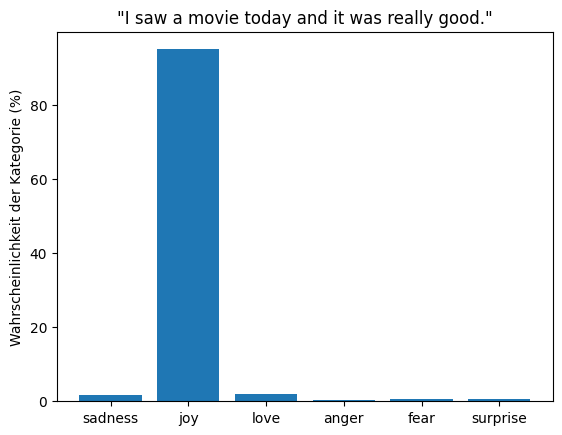

In [41]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

preds_df = pd.DataFrame(preds[0])
plt.bar(labels,100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Wahrscheinlichkeit der Kategorie (%)")
plt.show()